In [1]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

In [2]:
#Reading the input images
basedir = 'data/vehicles/'
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir+imtype+'/*'))

print("Number of Vehicle Images found: ", len(cars))

with open("cars.txt", "w") as f:
    for fn in cars:
        f.write(fn+'\n')
        
basedir = 'data/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir+imtype+'/*'))
print("Number of NonVehicle Images found: ", len(notcars))

with open("notcars.txt", "w") as f:
    for fn in notcars:
        f.write(fn+'\n')

Number of Vehicle Images found:  8792
Number of NonVehicle Images found:  8968


In [3]:
# Functions from the class.

# Returns HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Returns HOG image if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Else returns only the features
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features
    
# Slide Window Function Input: Image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

# Function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

# Function to extract features from a single image
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    img_features = []
    #Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    #Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    #Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis = vis, feature_vec=True)
                
            else:
                hog_features  = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis = vis, feature_vec=True)
                
    if vis == True:
        img_features.append(hog_features)
        return np.concatenate(img_features), hog_image
    
    else:
        img_features.append(hog_features)
        return np.concatenate(img_features)

# Search Windows Function Input: Image, 
# and the list of windows to be searched
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    for window in windows:
        #Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        #If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    return on_windows

#Function to convert between color formats
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
#Function to labeled draw bounding boxes    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img

#Function to get the heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

# Function to apply threshold to the heatmap 
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

# Function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
   
    boxes = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    
    #Features per block
    nfeat_per_block = orient*cell_per_block**2
   
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
   
    #The number of steps to extract features
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    #extracting 3 sets of features, one for each channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extracting the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Getting color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scaling features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    heatmap = add_heat(heatmap, boxes)
    apply_threshold(heatmap, 1)
    return draw_img, heatmap    

In [4]:
# Function to plot images
def plot_figures(fig, rows, cols, imgs):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


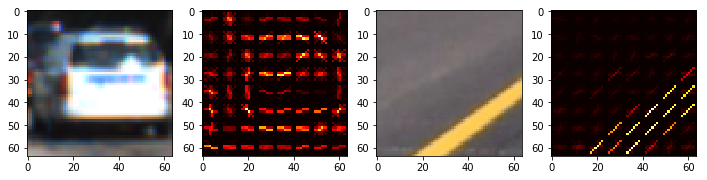

In [5]:
%matplotlib inline
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

#Define feature parameters
color_space = 'RGB'
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image = single_img_features(car_image, color_space=color_space,spatial_size=spatial_size,hist_bins=hist_bins,
                                                  orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                  hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                                                  hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat,
                                                 hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car hog image', 'notcar image', 'notcar hog image']
fig = plt.figure(figsize=(12,3))
plot_figures(fig, 1,4, images)

In [6]:
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0,len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, color_space = color_space, spatial_size = spatial_size, 
                               hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block, hog_channel = hog_channel,
                               spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

notcar_features = extract_features(test_notcars, color_space = color_space, spatial_size = spatial_size, 
                               hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                               cell_per_block = cell_per_block, hog_channel = hog_channel,
                               spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

print(time.time() - t,'Seconds to complete')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('number of features = ', X.shape[1])

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_number = np.random.randint(0,100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state = rand_number)

# Classifier

svc = LinearSVC()

t= time.time()

svc.fit(X_train,y_train)

print(time.time() - t, 'Seconds to train the model')


#Accuracy 
accu = round(svc.score(X_test, y_test),4)
print('The accuracy on the test set is:',accu)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


213.27017903327942 Seconds to complete
number of features =  8460
10.702566146850586 Seconds to train the model
The accuracy on the test set is: 0.9904


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


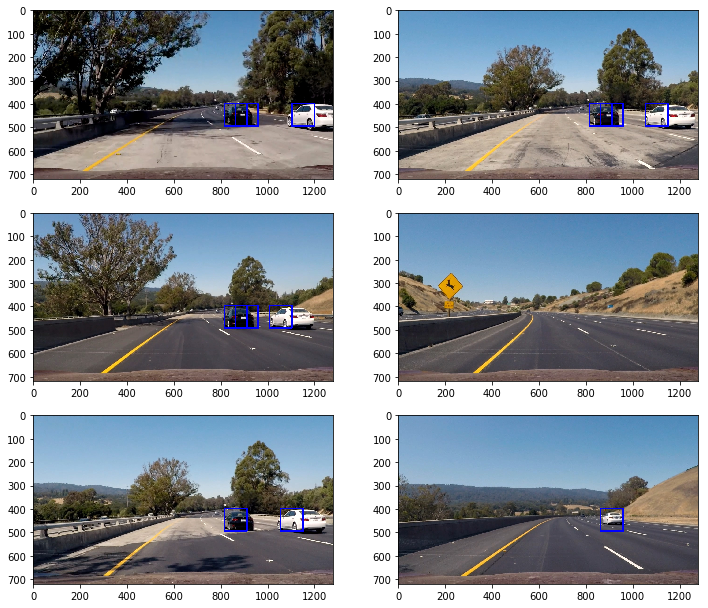

In [7]:
test_path = 'test_images/test*'
test_images = glob.glob(test_path)
images = []
titles = []
x_start_stop = [None, None]
y_start_stop = [350, 656]
overlap = 0.5
for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop, y_start_stop, xy_window = (96, 96), xy_overlap = (overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, spatial_size = spatial_size,
                                hist_bins = hist_bins, orient = orient, pix_per_cell = pix_per_cell,
                                cell_per_block = cell_per_block, hog_channel = hog_channel, spatial_feat = spatial_feat,
                                hist_feat = hist_feat, hog_feat=hog_feat)
    
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick = 6)
    
    images.append(window_img)
    titles.append('')
fig = plt.figure(figsize=(12,18))
plot_figures(fig, 5, 2, images)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


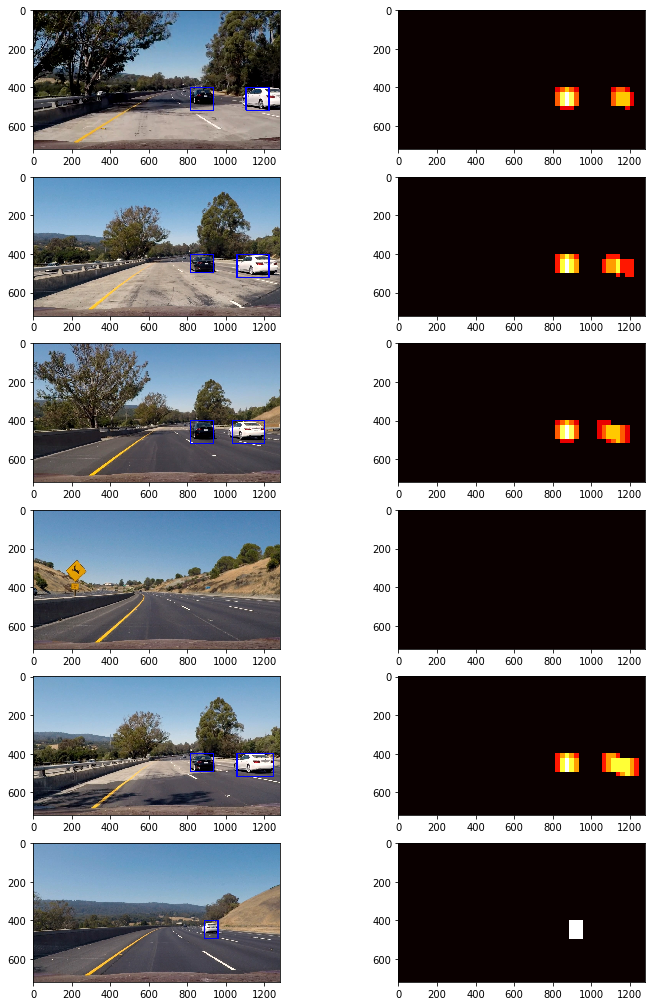

In [8]:
ystart = 400
ystop = 656
scale = 1.5

heat_maps = []
final_images = []
#loop thru the test images
for img_src in test_images:
    img = mpimg.imread(img_src)
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(out_img, labels)
    final_images.append(draw_img)
    final_images.append(heatmap)
    heat_maps.append(heatmap)
    
fig = plt.figure(figsize=(12,24))
plot_figures(fig, 8, 2, final_images)

In [9]:
def process_image(img):
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(out_img, labels)
    return draw_img

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = "output_video.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)

test_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████▉| 1260/1261 [16:59<00:00,  1.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 



In [11]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(output_video))